In [133]:
!pip install -U scikit-learn
!pip install autograd

## Preliminary: the softmax function

The softmax function plays a crucial role in neural networks, particularly in the output layer of classification models. Its primary purpose is to convert a vector of real numbers into a probability distribution over multiple classes.

$$\text{Softmax}(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
 $$

First, each element of the input vector is exponentiated (raised to the power of $e$), which makes all values positive.  The exponentiation step amplifies the differences between the input values. Larger values get significantly larger, and smaller values remain relatively small. This emphasizes the model's confidence in its predictions.

After exponentiation, the softmax function normalizes the values by dividing each exponentiated value by the sum of all exponentiated values in the input vector. This step ensures that the output vector sums up to 1, making it a valid probability distribution.

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the following 2-class dataset:

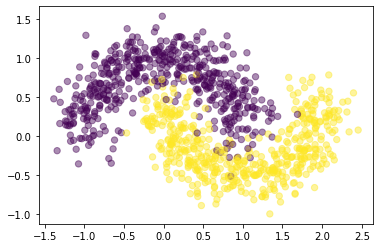

In [134]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

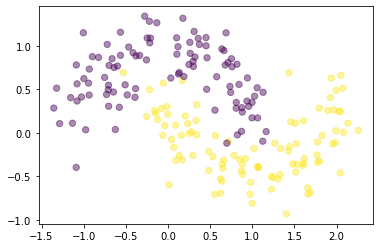

In [135]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [136]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [137]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer.

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2).
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2).

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \text{Softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network.

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$.


## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**.

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [138]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [139]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [140]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

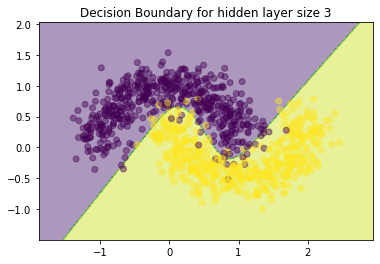

In [141]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [142]:
# Get the predictions for the testing dataset
predictions = predict(model, Xt)

# Calculate the accuracy from predicted labels compared with the actual labels
accuracy = np.mean(predictions == yt) * 100

# Show the results
print("Accuracy for the Testing Dataset: {:.2f}%".format(accuracy))

Accuracy for the Testing Dataset: 95.50%


# Exercise 2

+ Add an additional layer to your neural network model.
+ Change the activation function and use a ReLU.
+ Report the classification accuracy using the testing dataset.


In [143]:
num_examples = len(X)  #training dataset

# ReLU
def relu(x):
    return np.maximum(0, x)

# Loss function now with andditional layer using RELU
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # Forward propagation to calculate predictions
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculate the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1. / num_examples * data_loss

# Forward propagation like before, but now with additional layer
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    return np.argmax(probs, axis=1)

In [144]:
# Build the model with an additional hidden layer and ReLU activation
def build_model(nn_hdim1,nn_hdim2, num_passes=50000, print_loss=False):

  #initialize parameters with random values
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim1) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim1))
    W2 = np.random.randn(nn_hdim1, nn_hdim2) / np.sqrt(nn_hdim1)
    b2 = np.zeros((1, nn_hdim2))
    W3 = np.random.randn(nn_hdim2, nn_output_dim) / np.sqrt(nn_hdim2)
    b3 = np.zeros((1, nn_output_dim))

    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3} #return value

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build the model
model = build_model(3, 2, print_loss=True)

Loss after iteration 0: 0.725958
Loss after iteration 1000: 0.318398
Loss after iteration 2000: 0.284127
Loss after iteration 3000: 0.277145
Loss after iteration 4000: 0.273733
Loss after iteration 5000: 0.270931
Loss after iteration 6000: 0.268370
Loss after iteration 7000: 0.265980
Loss after iteration 8000: 0.263824
Loss after iteration 9000: 0.262037
Loss after iteration 10000: 0.260590
Loss after iteration 11000: 0.259358
Loss after iteration 12000: 0.258296
Loss after iteration 13000: 0.257340
Loss after iteration 14000: 0.256484
Loss after iteration 15000: 0.255724
Loss after iteration 16000: 0.255065
Loss after iteration 17000: 0.254482
Loss after iteration 18000: 0.253983
Loss after iteration 19000: 0.253509
Loss after iteration 20000: 0.253102
Loss after iteration 21000: 0.252752
Loss after iteration 22000: 0.252435
Loss after iteration 23000: 0.252151
Loss after iteration 24000: 0.251921
Loss after iteration 25000: 0.251703
Loss after iteration 26000: 0.251519
Loss after ite

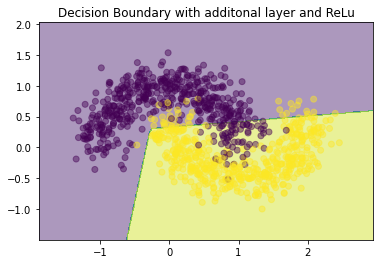

In [145]:
# Plot the decision boundary
def plot_decision_boundary(pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary with additonal layer and ReLu")
plt.show()

In [146]:
# Get the predictions for the testing dataset
predictions = predict(model, Xt)

# Calculate the accuracy from predicted labels compared with the actual labels
accuracy = np.mean(predictions == yt) * 100

# Show the results
print("Accuracy for the Testing Dataset: {:.2f}%".format(accuracy))

Accuracy for the Testing Dataset: 89.00%


# Exercise 3

+ Design your own model (number of layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. The objective is to get a **smooth** decision boundary (it will generalize better than a non-smooth one).
+ Train the model and report the classification accuracy using the testing dataset.


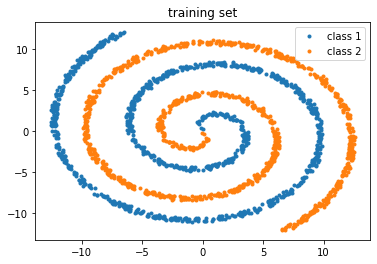

In [147]:
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)
y = y.astype(int)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

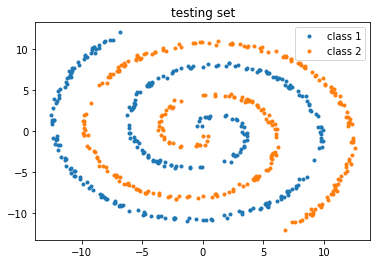

In [148]:
Xt, yt = twospirals(300)

plt.title('testing set')
plt.plot(Xt[yt==0,0], Xt[yt==0,1], '.', label='class 1')
plt.plot(Xt[yt==1,0], Xt[yt==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [149]:
X[1], X.shape

(array([-10.91585358,  -4.60882359]), (2000, 2))

In [150]:
y[1], y.shape

(0, (2000,))

In [151]:
import autograd.numpy as anp

num_examples = len(X)  #training dataset

# ReLU
def relu(x):
    return anp.maximum(0, x)

# Loss function now with andditional layer using RELU
def loss(model):
    W1, b1, W2, b2, W3, b3 ,W4, b4  = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4']

    # Forward propagation to calculate predictions
    z1 = anp.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = anp.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = anp.dot(a2, W3) + b3
    a3 = relu(z3)
    z4 = anp.dot(a3, W4) + b4
    exp_scores = anp.exp(z4)
    probs = exp_scores / anp.sum(exp_scores, axis=1, keepdims=True)

    # Calculate the loss
    corect_logprobs = -anp.log(probs[range(num_examples), y])
    data_loss = anp.sum(corect_logprobs)

    return 1. / num_examples * data_loss

# Forward propagation like before, but now with additional layer
def predict(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4  = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4']
    z1 = anp.dot(x, W1) + b1
    a1 = relu(z1)
    z2 = anp.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = anp.dot(a2, W3) + b3
    a3 = relu(z3)
    z4 = anp.dot(a3, W4) + b4
    exp_scores = anp.exp(z4)
    probs = exp_scores / anp.sum(exp_scores, axis=1, keepdims=True)

    return anp.argmax(probs, axis=1)

In [152]:
 # Build the model with an additional hidden layer and ReLU activation
def build_model(nn_hdim1,nn_hdim2,nn_hdim3, num_passes=50000, print_loss=False):

  #initialize parameters with random values
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim1) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim1))
    W2 = np.random.randn(nn_hdim1, nn_hdim2) / np.sqrt(nn_hdim1)
    b2 = np.zeros((1, nn_hdim2))
    W3 = np.random.randn(nn_hdim2, nn_hdim3) / np.sqrt(nn_hdim2)
    b3 = np.zeros((1, nn_hdim3))
    W4 = np.random.randn(nn_hdim3, nn_output_dim) / np.sqrt(nn_hdim3)
    b4 = np.zeros((1, nn_output_dim))

    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3,  'W4': W4, 'b4': b4} #return value

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build the model
model = build_model(32, 16 ,4 ,print_loss=True)

Loss after iteration 0: 0.709096
Loss after iteration 1000: 0.656597
Loss after iteration 2000: 0.653608
Loss after iteration 3000: 0.651801
Loss after iteration 4000: 0.650352
Loss after iteration 5000: 0.647560
Loss after iteration 6000: 0.645433
Loss after iteration 7000: 0.643731
Loss after iteration 8000: 0.640733
Loss after iteration 9000: 0.634266
Loss after iteration 10000: 0.629302
Loss after iteration 11000: 0.626259
Loss after iteration 12000: 0.623659
Loss after iteration 13000: 0.623375
Loss after iteration 14000: 0.623093
Loss after iteration 15000: 0.621814
Loss after iteration 16000: 0.621362
Loss after iteration 17000: 0.620098
Loss after iteration 18000: 0.619141
Loss after iteration 19000: 0.618840
Loss after iteration 20000: 0.618616
Loss after iteration 21000: 0.617232
Loss after iteration 22000: 0.616807
Loss after iteration 23000: 0.616597
Loss after iteration 24000: 0.615530
Loss after iteration 25000: 0.615235
Loss after iteration 26000: 0.615117
Loss after ite

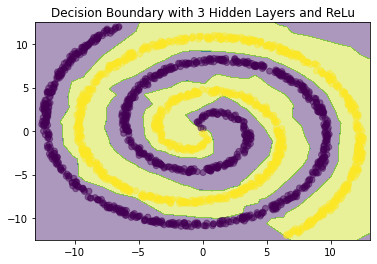

In [153]:
# Plot the decision boundary
def plot_decision_boundary(pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary with 3 Hidden Layers and ReLu")
plt.show()

In [154]:
# Get the predictions for the testing dataset
predictions = predict(model, Xt)

# Calculate the accuracy from predicted labels compared with the actual labels
accuracy = np.mean(predictions == yt) * 100

# Show the results
print("Accuracy for the Testing Dataset: {:.2f}%".format(accuracy))

Accuracy for the Testing Dataset: 99.83%
